In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

In [3]:
# Init SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 15:20:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("/kaggle/input/weather-prediction-rnn-and-cnn/weather_dataset.csv", header=True, inferSchema=True)

In [5]:
df.show(5)

25/05/20 15:20:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country| lat|     lon|           tz_id|          localtime|      date|               time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+------

In [6]:
df.createOrReplaceTempView("weather_dataset")

In [7]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------------+-------+---+---+-----+---------+----+----+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country|lat|lon|tz_id|localtime|date|time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+---+---+-----+---------+----+----+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+--

In [8]:
from pyspark.sql.functions import countDistinct

for col_name in df.columns:
    unique_count = df.select(countDistinct(col_name)).collect()[0][0]
    print(f"Column '{col_name}' has {unique_count} unique values.")


Column 'location_name' has 63 unique values.


Column 'country' has 1 unique values.


Column 'lat' has 62 unique values.


Column 'lon' has 62 unique values.


Column 'tz_id' has 2 unique values.


Column 'localtime' has 255 unique values.


Column 'date' has 367 unique values.


Column 'time' has 8808 unique values.


Column 'temp_c' has 425 unique values.


Column 'temp_f' has 740 unique values.


Column 'is_day' has 2 unique values.


Column 'condition_text' has 21 unique values.


Column 'wind_mph' has 310 unique values.


Column 'wind_kph' has 456 unique values.


Column 'wind_degree' has 361 unique values.


Column 'wind_dir' has 16 unique values.


Column 'pressure_mb' has 67 unique values.


Column 'pressure_in' has 175 unique values.


Column 'precip_mm' has 1010 unique values.


Column 'precip_in' has 119 unique values.


Column 'humidity' has 92 unique values.


Column 'cloud' has 101 unique values.


Column 'feelslike_c' has 506 unique values.


Column 'feelslike_f' has 876 unique values.


Column 'windchill_c' has 442 unique values.


Column 'windchill_f' has 771 unique values.


Column 'heatindex_c' has 486 unique values.


Column 'heatindex_f' has 839 unique values.


Column 'dewpoint_c' has 356 unique values.


Column 'dewpoint_f' has 622 unique values.


Column 'vis_km' has 22 unique values.


Column 'vis_miles' has 7 unique values.


Column 'uv' has 11 unique values.


Column 'gust_mph' has 521 unique values.


Column 'gust_kph' has 792 unique values.


Column 'will_it_rain' has 2 unique values.


Column 'chance_of_rain' has 3 unique values.


In [9]:
df = df.drop('country','lat','lon', 'date','tz_id','localtime','temp_f','wind_kph', 'feelslike_c','feelslike_f',
        'pressure_in','heatindex_f','precip_in','windchill_f', 'dewpoint_f','vis_miles','gust_kph')

In [10]:
df.columns

['location_name',
 'time',
 'temp_c',
 'is_day',
 'condition_text',
 'wind_mph',
 'wind_degree',
 'wind_dir',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain',
 'chance_of_rain']

In [11]:
from pyspark.ml.feature import StringIndexer

indexer_location = StringIndexer(inputCol="location_name", outputCol="location")
indexer_condition = StringIndexer(inputCol="condition_text", outputCol="condition")
indexer_wind_dir = StringIndexer(inputCol="wind_dir", outputCol="wind_direct")

df = indexer_location.fit(df).transform(df)
df = indexer_condition.fit(df).transform(df)
df = indexer_wind_dir.fit(df).transform(df)

df.show(5)


+-------------+-------------------+------+------+--------------+--------+-----------+--------+-----------+---------+--------+-----+-----------+-----------+----------+------+---+--------+------------+--------------+--------+---------+-----------+
|location_name|               time|temp_c|is_day|condition_text|wind_mph|wind_degree|wind_dir|pressure_mb|precip_mm|humidity|cloud|windchill_c|heatindex_c|dewpoint_c|vis_km| uv|gust_mph|will_it_rain|chance_of_rain|location|condition|wind_direct|
+-------------+-------------------+------+------+--------------+--------+-----------+--------+-----------+---------+--------+-----+-----------+-----------+----------+------+---+--------+------------+--------------+--------+---------+-----------+
|     Chau Doc|2024-04-25 00:00:00|  30.0|     0|         Clear|     9.2|        191|     SSW|     1008.0|      0.0|      65|   19|       30.0|       34.0|      22.7|  10.0|0.0|    12.9|           0|             0|    13.0|      4.0|       12.0|
|     Chau Doc|2

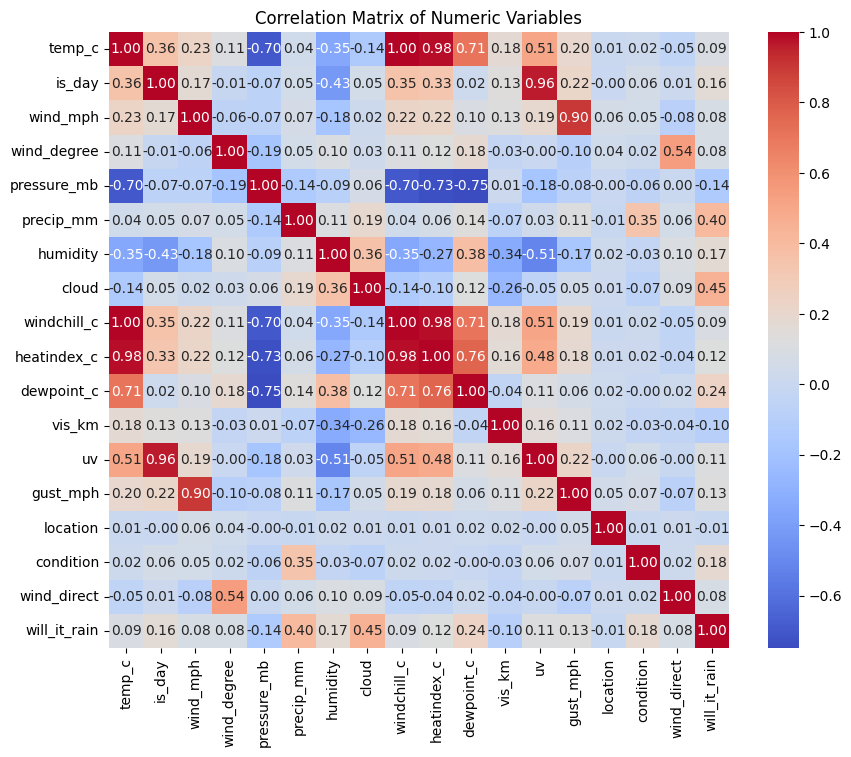

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'location',
 'condition',
 'wind_direct',
 'will_it_rain',]

correlation_matrix = df.select(numeric_columns).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()


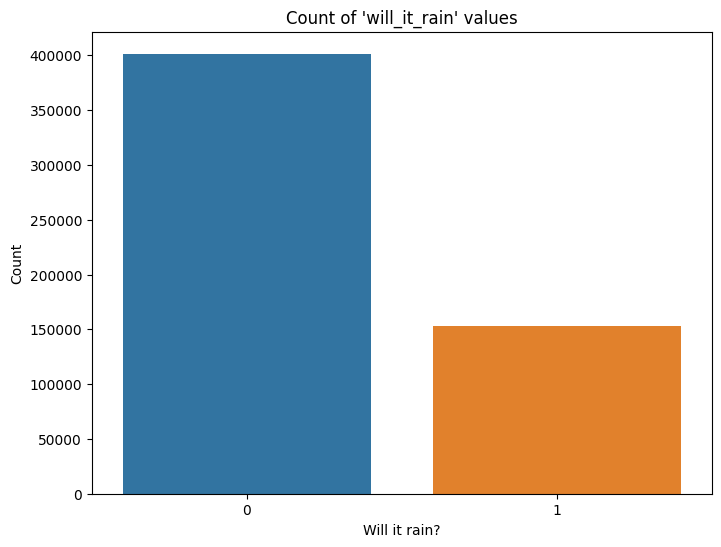

In [13]:
import matplotlib.pyplot as plt

will_it_rain_counts = df.groupBy("will_it_rain").count().toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="will_it_rain", y="count", data=will_it_rain_counts)
plt.title("Count of 'will_it_rain' values")
plt.xlabel("Will it rain?")
plt.ylabel("Count")
plt.show()


In [19]:
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
from pyspark.ml.feature import StringIndexer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
df_temp = df.select(
    'location_name', 'time', 'temp_c', 'is_day', 'wind_mph', 'wind_degree', 
    'precip_mm', 'humidity', 'cloud', 'vis_km', 'uv', 'gust_mph', 'condition_text', 'wind_dir'
)

In [17]:
df_rain = df['location_name',
 'location',
 'time',
 'temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain',
 'chance_of_rain',
 'condition_text',
 'wind_dir']

In [20]:
# Sắp xếp dữ liệu theo location_name và time
window_spec = Window.orderBy("location_name", "time")
df_temp = df_temp.withColumn("prev_temp_c", lag("temp_c", 1).over(window_spec))
df_rain = df_rain.withColumn("prev_chance_of_rain", lag("chance_of_rain", 1).over(window_spec))

In [21]:
# Lọc ra các hàng có đủ dữ liệu
df_temp = df_temp.filter(col("prev_temp_c").isNotNull())
df_rain = df_rain.filter(col("prev_chance_of_rain").isNotNull())

In [22]:
# Mã hóa cột condition_text và wind_dir
indexer_condition = StringIndexer(inputCol="condition_text", outputCol="condition_index")
indexer_wind = StringIndexer(inputCol="wind_dir", outputCol="wind_dir_index")
df_temp = indexer_condition.fit(df_temp).transform(df_temp)
df_temp = indexer_wind.fit(df_temp).transform(df_temp)
df_rain = indexer_condition.fit(df_rain).transform(df_rain)
df_rain = indexer_wind.fit(df_rain).transform(df_rain)

25/05/20 15:27:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 1

In [23]:
# Chuyển sang Pandas để tạo chuỗi (lấy dữ liệu cho một địa điểm, ví dụ: Chau Doc)
pandas_temp = df_temp.filter(col("location_name") == "Chau Doc").toPandas()
pandas_rain = df_rain.filter(col("location_name") == "Chau Doc").toPandas()

25/05/20 15:27:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:27:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 15:28:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/20 1

In [24]:
# Lấy các cột đặc trưng
temp_features = ['temp_c', 'is_day', 'wind_mph', 'wind_degree', 'precip_mm', 'humidity',
                 'cloud', 'vis_km', 'uv', 'gust_mph', 'condition_index', 'wind_dir_index']
rain_features = ['temp_c', 'is_day', 'wind_mph', 'wind_degree', 'pressure_mb', 'precip_mm',
                 'humidity', 'cloud', 'windchill_c', 'heatindex_c', 'dewpoint_c', 'vis_km',
                 'uv', 'gust_mph', 'condition_index', 'wind_dir_index']

In [25]:
# Tạo chuỗi thời gian (timesteps = 24)
timesteps = 24
X_temp, y_temp = [], []
X_rain, y_rain = [], []

for i in range(len(pandas_temp) - timesteps):
    X_temp.append(pandas_temp[temp_features].iloc[i:i+timesteps].values)
    y_temp.append(pandas_temp['temp_c'].iloc[i+timesteps])

for i in range(len(pandas_rain) - timesteps):
    X_rain.append(pandas_rain[rain_features].iloc[i:i+timesteps].values)
    y_rain.append(pandas_rain['chance_of_rain'].iloc[i+timesteps])

X_temp = np.array(X_temp)
y_temp = np.array(y_temp)
X_rain = np.array(X_rain)
y_rain = np.array(y_rain)

In [26]:

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
scaler_X_temp = StandardScaler()
scaler_y_temp = StandardScaler()
scaler_X_rain = StandardScaler()
scaler_y_rain = StandardScaler()

X_temp = scaler_X_temp.fit_transform(X_temp.reshape(-1, X_temp.shape[-1])).reshape(X_temp.shape)
y_temp = scaler_y_temp.fit_transform(y_temp.reshape(-1, 1))
X_rain = scaler_X_rain.fit_transform(X_rain.reshape(-1, X_rain.shape[-1])).reshape(X_rain.shape)
y_rain = scaler_y_rain.fit_transform(y_rain.reshape(-1, 1) / 100)  # Chuẩn hóa chance_of_rain về [0, 1]

In [27]:
from sklearn.model_selection import train_test_split
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_rain_train, X_rain_test, y_rain_train, y_rain_test = train_test_split(X_rain, y_rain, test_size=0.2, random_state=42)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Xây dựng mô hình
model_temp = Sequential([
    LSTM(64, input_shape=(timesteps, X_temp.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Đầu ra là giá trị nhiệt độ
])

# Biên dịch mô hình
model_temp.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
history_temp = model_temp.fit(X_temp_train, y_temp_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

2025-05-20 15:29:13.546936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747754953.776904      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747754953.842149      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 15:29:28.214307: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.4067 - val_loss: 0.0776
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0883 - val_loss: 0.0606
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0772 - val_loss: 0.0518
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0681 - val_loss: 0.0501
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0613 - val_loss: 0.0455
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0579 - val_loss: 0.0469
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0561 - val_loss: 0.0429
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0519 - val_loss: 0.0414
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0498 - val_loss: 0.0418
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0487 - val_loss: 0.0381
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0470 - val_loss: 0.0415
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━

In [32]:
y_temp_pred = model_temp.predict(X_temp_test)
y_temp_pred = scaler_y_temp.inverse_transform(y_temp_pred)
y_temp_test = scaler_y_temp.inverse_transform(y_temp_test)
print("MSE nhiệt độ:", np.mean((y_temp_pred - y_temp_test) ** 2))

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
MSE nhiệt độ: 0.33742917796914595


In [36]:
{
  "type": "line",
  "data": {
    "labels": [f"{i}:00" for i in range(24)],
    "datasets": [{
      "label": "Nhiệt độ thực tế (°C)",
      "data": y_temp_test[0].tolist(),
      "borderColor": "#FF6384",
      "fill": False
    }, {
      "label": "Nhiệt độ dự đoán (°C)",
      "data": y_temp_pred[0].tolist(),
      "borderColor": "#36A2EB",
      "fill": False
    }]
  },
  "options": {
    "responsive": True,
    "title": {
      "display": True,
      "text": "Dự đoán Nhiệt độ trong 24 giờ - Chau Doc"
    },
    "scales": {
      "yAxes": [{
        "scaleLabel": {
          "display": True,
          "labelString": "Nhiệt độ (°C)"
        }
      }]
    }
  }
}

{'type': 'line',
 'data': {'labels': ['0:00',
   '1:00',
   '2:00',
   '3:00',
   '4:00',
   '5:00',
   '6:00',
   '7:00',
   '8:00',
   '9:00',
   '10:00',
   '11:00',
   '12:00',
   '13:00',
   '14:00',
   '15:00',
   '16:00',
   '17:00',
   '18:00',
   '19:00',
   '20:00',
   '21:00',
   '22:00',
   '23:00'],
  'datasets': [{'label': 'Nhiệt độ thực tế (°C)',
    'data': [22.5],
    'borderColor': '#FF6384',
    'fill': False},
   {'label': 'Nhiệt độ dự đoán (°C)',
    'data': [23.173503875732422],
    'borderColor': '#36A2EB',
    'fill': False}]},
 'options': {'responsive': True,
  'title': {'display': True,
   'text': 'Dự đoán Nhiệt độ trong 24 giờ - Chau Doc'},
  'scales': {'yAxes': [{'scaleLabel': {'display': True,
      'labelString': 'Nhiệt độ (°C)'}}]}}}

In [29]:
# Xây dựng mô hình
model_rain = Sequential([
    LSTM(64, input_shape=(timesteps, X_rain.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Đầu ra là xác suất mưa (0-1)
])

# Biên dịch mô hình
model_rain.compile(optimizer='adam', loss='mse')  # Sử dụng MSE vì chance_of_rain là giá trị liên tục

# Huấn luyện mô hình
history_rain = model_rain.fit(X_rain_train, y_rain_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.9581 - val_loss: 0.8468
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.7794 - val_loss: 0.7934
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7685 - val_loss: 0.7803
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.7356 - val_loss: 0.8144
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.7336 - val_loss: 0.7687
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7225 - val_loss: 0.7588
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.7093 - val_loss: 0.7503
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.6949 - val_loss: 0.7494
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.6837 - val_loss: 0.7374
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.6862 - val_loss: 0.7407
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.6807 - val_loss: 0.7251
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━

In [35]:
y_rain_pred = model_rain.predict(X_rain_test)
y_rain_pred = scaler_y_rain.inverse_transform(y_rain_pred) * 100
y_rain_test = scaler_y_rain.inverse_transform(y_rain_test) * 100
print("MSE khả năng mưa:", np.mean((y_rain_pred - y_rain_test) ** 2))

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
MSE khả năng mưa: 1451.6880744366372


In [37]:
{
  "type": "line",
  "data": {
    "labels": [f"{i}:00" for i in range(24)],
    "datasets": [{
      "label": "Khả năng mưa thực tế (%)",
      "data": y_rain_test[0].tolist(),
      "borderColor": "#FF6384",
      "fill": False
    }, {
      "label": "Khả năng mưa dự đoán (%)",
      "data": y_rain_pred[0].tolist(),
      "borderColor": "#36A2EB",
      "fill": False
    }]
  },
  "options": {
    "responsive": True,
    "title": {
      "display": True,
      "text": "Dự đoán Khả năng Mưa trong 24 giờ - Chau Doc"
    },
    "scales": {
      "yAxes": [{
        "scaleLabel": {
          "display": True,
          "labelString": "Khả năng mưa (%)"
        },
        "ticks": {
          "beginAtZero": True,
          "max": 100
        }
      }]
    }
  }
}

{'type': 'line',
 'data': {'labels': ['0:00',
   '1:00',
   '2:00',
   '3:00',
   '4:00',
   '5:00',
   '6:00',
   '7:00',
   '8:00',
   '9:00',
   '10:00',
   '11:00',
   '12:00',
   '13:00',
   '14:00',
   '15:00',
   '16:00',
   '17:00',
   '18:00',
   '19:00',
   '20:00',
   '21:00',
   '22:00',
   '23:00'],
  'datasets': [{'label': 'Khả năng mưa thực tế (%)',
    'data': [0.0],
    'borderColor': '#FF6384',
    'fill': False},
   {'label': 'Khả năng mưa dự đoán (%)',
    'data': [27.003074645996094],
    'borderColor': '#36A2EB',
    'fill': False}]},
 'options': {'responsive': True,
  'title': {'display': True,
   'text': 'Dự đoán Khả năng Mưa trong 24 giờ - Chau Doc'},
  'scales': {'yAxes': [{'scaleLabel': {'display': True,
      'labelString': 'Khả năng mưa (%)'},
     'ticks': {'beginAtZero': True, 'max': 100}}]}}}